# **سلول اول: دانلود و ذخیره دیتا**

In [1]:
!pip install requests pandas gradio numpy scikit-learn xgboost matplotlib tensorflow backtesting ipython

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.0/322.0 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 187.9/187.9 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.8/94.8 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.6/12.6 MB 19.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.5/71.5 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 3.4 MB/s eta 0:00:00
  Attempting uninstall: markupsafe
    Found existing installation: MarkupSafe 3.0.2
    Uninstalling MarkupSafe-3.0.2:
      Successfully uninstalled MarkupSafe-3.0.2


In [ ]:
# %%
import gradio as gr
import pandas as pd
import os
import zipfile
import requests
import io

def read_data(file_or_link):
    """
    Reads data from a file, a folder, or a ZIP file based on the input.

    Args:
        file_or_link (str or list): The file path, folder path, or a link to a ZIP file.

    Returns:
        pd.DataFrame: The combined DataFrame.
    """
    if isinstance(file_or_link, list):
       #handle upload file
        if len(file_or_link) == 1:
            if file_or_link[0].endswith('.zip'):
                return read_and_concatenate_data_from_zip(file_or_link[0])
            else:
                return pd.read_csv(file_or_link[0])
        else :
            dfs = []
            for file in file_or_link:
                dfs.append(pd.read_csv(file))
            return pd.concat(dfs, ignore_index=True)

    elif file_or_link.startswith('http'):
        # Handle download from link
        if file_or_link.endswith('.zip'):
            response = requests.get(file_or_link, stream=True)
            response.raise_for_status()
            with zipfile.ZipFile(io.BytesIO(response.content)) as zip_ref:
                return read_and_concatenate_data_from_zip_object(zip_ref)
        elif file_or_link.endswith('.csv'):
            response = requests.get(file_or_link)
            response.raise_for_status()
            return pd.read_csv(io.StringIO(response.text))
        else:
             raise ValueError("Invalid file type. Only ZIP or CSV files are supported.")
    elif os.path.isfile(file_or_link):
        # Handle single file
        if file_or_link.endswith('.zip'):
            return read_and_concatenate_data_from_zip(file_or_link)
        elif file_or_link.endswith('.csv'):
            return pd.read_csv(file_or_link)
        else:
             raise ValueError("Invalid file type. Only ZIP or CSV files are supported.")

    elif os.path.isdir(file_or_link):
        # Handle folder
        return read_and_concatenate_data_from_folder(file_or_link)

    else:
        raise ValueError("Invalid input. Please provide a valid file path, folder path, or link.")

def read_and_concatenate_data_from_folder(folder_path):
    """
    Reads all CSV files in a folder and concatenates them into a single DataFrame.

    Args:
        folder_path (str): The path to the folder containing the CSV files.

    Returns:
        pd.DataFrame: The concatenated DataFrame.
    """
    all_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('.csv')]
    dfs = []
    for file in all_files:
        df = pd.read_csv(file)
        dfs.append(df)
    return pd.concat(dfs, ignore_index=True)

def read_and_concatenate_data_from_zip(zip_file_path):
    """
    Reads all CSV files in a ZIP file and concatenates them into a single DataFrame.

    Args:
        zip_file_path (str): The path to the ZIP file.

    Returns:
        pd.DataFrame: The concatenated DataFrame.
    """
    dfs = []
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        for file_name in zip_ref.namelist():
            if file_name.endswith('.csv'):
                with zip_ref.open(file_name) as file:
                    df = pd.read_csv(file)
                    dfs.append(df)
    return pd.concat(dfs, ignore_index=True)

def read_and_concatenate_data_from_zip_object(zip_ref):
    """
    Reads all CSV files in a ZIP file object and concatenates them into a single DataFrame.

    Args:
        zip_ref: A zipfile.ZipFile object.

    Returns:
        pd.DataFrame: The concatenated DataFrame.
    """
    dfs = []
    for file_name in zip_ref.namelist():
        if file_name.endswith('.csv'):
            with zip_ref.open(file_name) as file:
                df = pd.read_csv(file)
                dfs.append(df)
    return pd.concat(dfs, ignore_index=True)

def process_data(file_or_link):
    """
    Processes the uploaded data and returns the combined DataFrame.

    Args:
        file_or_link (str or list): The file path, folder path, or link to a ZIP file.

    Returns:
        pd.DataFrame: The processed DataFrame.
    """
    try:
        combined_df = read_data(file_or_link)
        return combined_df
    except Exception as e:
        return f"An error occurred: {e}"

# Create the Gradio interface
iface = gr.Interface(
    fn=process_data,
    inputs=[gr.Textbox(lines=1, placeholder="Enter file path or link here...") ,gr.File(file_count='multiple')],
    outputs="dataframe",
    title="Data Loader",
    description="Load data from a single file, multiple files, a folder, or a ZIP file.",
    allow_flagging="never"
)

iface.launch()

/usr/local/lib/python3.11/dist-packages/gradio/interface.py:403: UserWarning: The `allow_flagging` parameter in `Interface` is deprecated.Use `flagging_mode` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/gradio/utils.py:1024: UserWarning: Expected 1 arguments for function <function process_data at 0x79293f787a60>, received 2.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/gradio/utils.py:1032: UserWarning: Expected maximum 1 arguments for function <function process_data at 0x79293f787a60>, received 2.
  warnings.warn(


Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://016d589be3652b94cc.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [3]:
# prompt: دیتا را از لینک زیر بگیر وزخیره کن
# https://github.com/Khajavi8056/Hip/blob/main/EURUSD.csv

import requests
import pandas as pd
import io

url = "https://raw.githubusercontent.com/Khajavi8056/Hip/main/EURUSD.csv"

try:
    response = requests.get(url)
    response.raise_for_status()  # Raise an exception for bad status codes (4xx or 5xx)

    data = pd.read_csv(io.StringIO(response.text))
    data.to_csv("EURUSD.csv", index=False)  # Save to a local file named EURUSD.csv
    print("Data downloaded and saved to EURUSD.csv successfully.")

except requests.exceptions.RequestException as e:
    print(f"An error occurred during the request: {e}")

except pd.errors.ParserError as e:
    print(f"An error occurred during CSV parsing: {e}")

except Exception as e:
    print(f"An unexpected error occurred: {e}")

Data downloaded and saved to EURUSD.csv successfully.


# سلول دوم: بارگذاری و تمیزکاری **دیتا**

In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report
from sklearn.utils import resample
from xgboost import XGBClassifier
import matplotlib.pyplot as plt

#  dataset load
df = pd.read_csv("EURUSD.csv")


#Check if NA values are in data
df=df[df['volume']!=0]
df.reset_index(drop=True, inplace=True)
df.isna().sum()
df.tail()

,Gmt time,open,high,low,close,volume
28821,15.10.2021 01:00:00.000,1.15940,1.16120,1.15938,1.16082,5738.63
28822,15.10.2021 05:00:00.000,1.16082,1.16189,1.15995,1.16034,13149.66
28823,15.10.2021 09:00:00.000,1.16033,1.16124,1.15892,1.15923,14914.33
28824,15.10.2021 13:00:00.000,1.15923,1.16103,1.15893,1.15953,20002.53
28825,15.10.2021 17:00:00.000,1.15952,1.16060,1.15933,1.16040,5620.05


سلول سوم: نمایش داده‌ها روی چارت

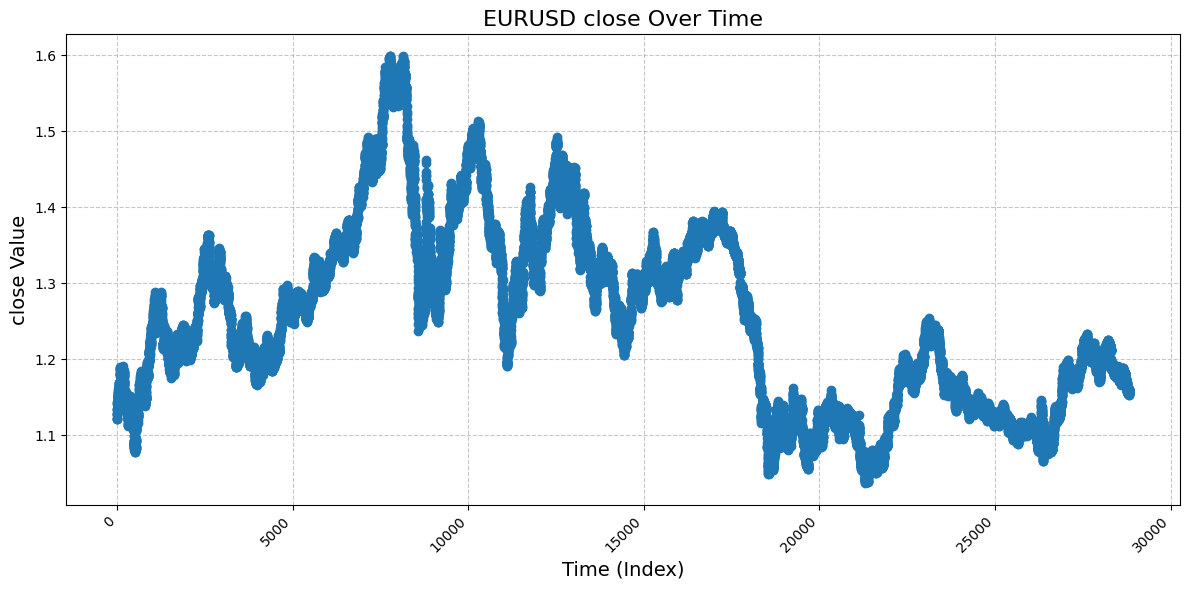

In [5]:
# prompt: نمایش دیتا روی چارت دیتای در سلول قبل به و نمودار با گیفیت تر

import matplotlib.pyplot as plt

# Assuming 'df' is your DataFrame from the previous code
# Replace 'column_name' with the actual column you want to plot
column_name = 'close'  # Example: plot the 'close' column

plt.figure(figsize=(12, 6))  # Adjust figure size for better visibility
plt.plot(df[column_name], marker='o', linestyle='-')  # Add markers and a line style

plt.title(f'EURUSD {column_name} Over Time', fontsize=16)
plt.xlabel('Time (Index)', fontsize=14)
plt.ylabel(f'{column_name} Value', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)  # Add a grid for better readability
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability


plt.tight_layout()  # Adjust layout to prevent labels from overlapping
plt.show()

# سلول  4.5: آماده سازی داده ها برای LSTM

# **سلول چهارم: مهندسی ویژگی**

In [8]:
# Calculate ATR, RSI, Moving Averages, and Slopes
def calculate_atr(df, length=20):
    df['high_low'] = df['high'] - df['low']
    df['high_close'] = np.abs(df['high'] - df['close'].shift(1)) #absolute difference between today's high price and yesterday's close price.
    df['low_close'] = np.abs(df['low'] - df['close'].shift(1))
    df['tr'] = df[['high_low', 'high_close', 'low_close']].max(axis=1)
    df['atr'] = df['tr'].rolling(window=length).mean()
    return df

def calculate_rsi(df, length=14):     #RSI is a momentum indicator that shows-- the market is overbought or oversold.
    delta = df['close'].diff(1)     #Calculates the day-to-day difference in closing prices (delta) by subtracting the previous day's close from the current day's close.
    gain = (delta.where(delta > 0, 0)).rolling(window=length).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=length).mean()
    rs = gain / loss                  #Calculates the relative strength (RS) as the ratio of the average gains to the average losses.
    df['rsi'] = 100 - (100 / (1 + rs))
    return df

def calculate_moving_averages(df, lengths=[40, 80, 160]):
    for length in lengths:
        df[f'MA{length}'] = df['close'].rolling(window=length).mean()
    return df

def calculate_slope(series):
    slope = np.gradient(series)
    return pd.Series(slope, name=f'{series.name}_slope')

df = calculate_atr(df) #    feature engineering (calculations)
df = calculate_rsi(df)
df = calculate_moving_averages(df, lengths=[40, 80, 160])

df['slope_MA40'] = calculate_slope(df['MA40']) # Add slopes for all (MA40, MA80, MA160, and RSI)
df['slope_MA80'] = calculate_slope(df['MA80'])
df['slope_MA160'] = calculate_slope(df['MA160'])
df['slope_RSI'] = calculate_slope(df['rsi'])

# Clean up temporary columns used for calculations
df.drop(columns=['high_low', 'high_close', 'low_close', 'tr'], inplace=True)

In [9]:
df.tail()

,Gmt time,open,high,low,close,volume,atr,rsi,MA40,MA80,MA160,slope_MA40,slope_MA80,slope_MA160,slope_RSI
28821,15.10.2021 01:00:00.000,1.15940,1.16120,1.15938,1.16082,5738.63,0.001954,70.710850,1.156618,1.159121,1.167880,0.000153,-0.000109,-0.000134,-0.815568
28822,15.10.2021 05:00:00.000,1.16082,1.16189,1.15995,1.16034,13149.66,0.001988,67.108168,1.156768,1.159014,1.167745,0.000117,-0.000120,-0.000138,-4.885812
28823,15.10.2021 09:00:00.000,1.16033,1.16124,1.15892,1.15923,14914.33,0.002039,60.939227,1.156853,1.158880,1.167604,0.000088,-0.000120,-0.000139,-3.171176
28824,15.10.2021 13:00:00.000,1.15923,1.16103,1.15893,1.15953,20002.53,0.002070,60.765816,1.156944,1.158774,1.167468,0.000106,-0.000101,-0.000134,3.224800
28825,15.10.2021 17:00:00.000,1.15952,1.16060,1.15933,1.16040,5620.05,0.001965,67.388826,1.157065,1.158678,1.167336,0.000121,-0.000096,-0.000132,6.623010


In [12]:
# %% [markdown]
# # 4.5 Data Preprocessing for LSTM
# %%
# Import necessary libraries
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

# Define sequence length
sequence_length = 60  # Example: Using the last 60 time steps (you can adjust this)

# Columns to use for LSTM
lstm_columns = ['close', 'open', 'high', 'low', 'volume','atr', 'rsi',  'MA40', 'MA80', 'MA160',    'slope_MA40',   'slope_MA80',   'slope_MA160',  'slope_RSI',    'signal']
lstm_data = df[lstm_columns].copy()

# Scale data
scaler = MinMaxScaler(feature_range=(0, 1)) # Create a scaler object
scaled_data = scaler.fit_transform(lstm_data) # fit on data and transform

# Create sequences and targets
X_lstm, y_lstm = [], [] #create two empty list
# create data for LSTM
for i in range(sequence_length, len(scaled_data)):
    X_lstm.append(scaled_data[i-sequence_length:i])
    y_lstm.append(scaled_data[i, 0]) # Target is the 'close' price (index 0)

# Convert lists to numpy arrays
X_lstm, y_lstm = np.array(X_lstm), np.array(y_lstm)

# Print shapes for verification
print("Shape of X_lstm:", X_lstm.shape)
print("Shape of y_lstm:", y_lstm.shape)

Shape of X_lstm: (28766, 60, 15)
Shape of y_lstm: (28766,)


سلول پنجم: نمایش دیتا با شاخص ها

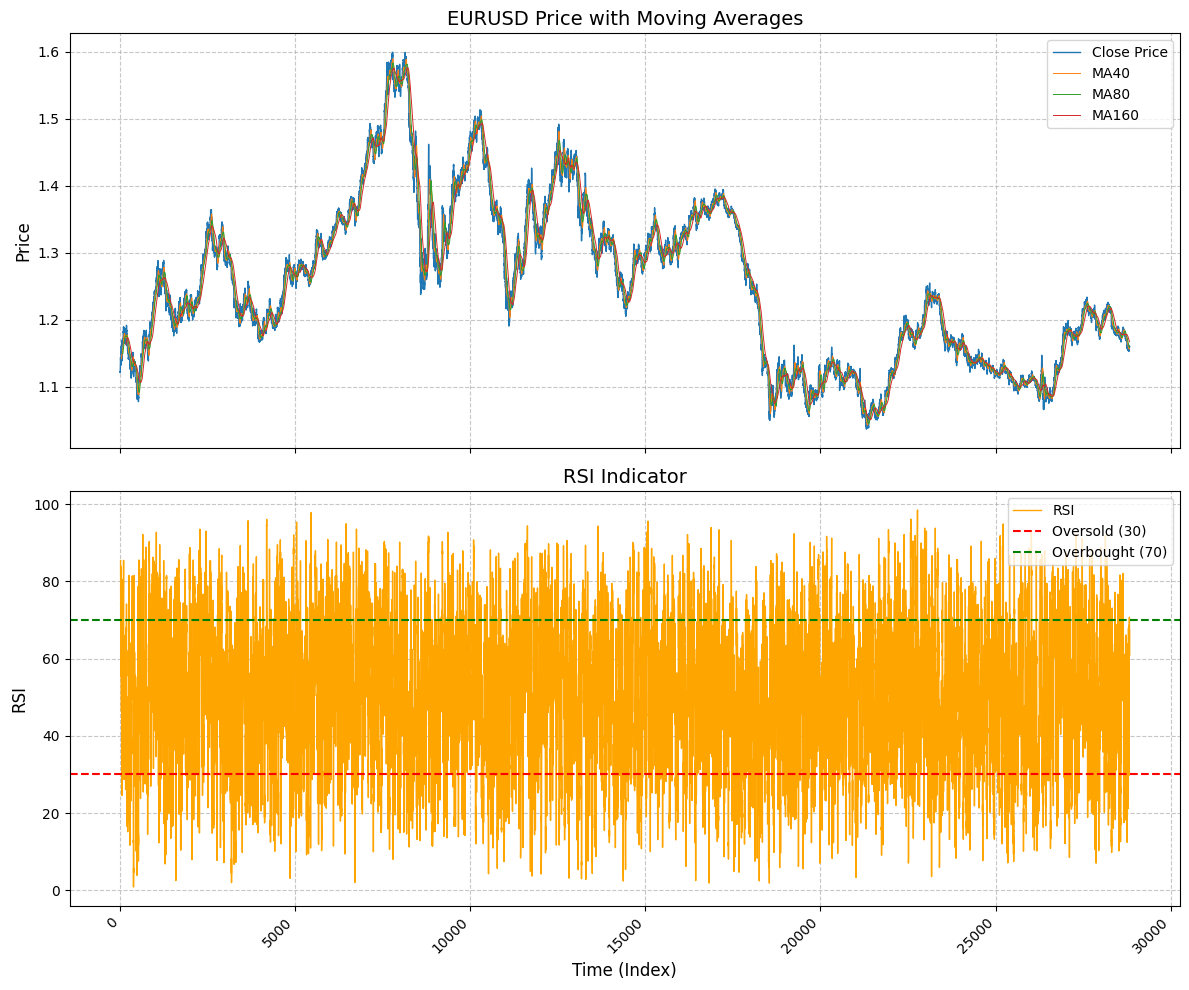

In [10]:

import requests
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt

# ... (your existing code for data loading and feature engineering) ...

# Plotting with separate subplots for price and indicators

fig, axes = plt.subplots(2, 1, figsize=(12, 10), sharex=True) #sharex to ensure that the x-axis is the same


# Plot price and moving averages on the first subplot
axes[0].plot(df['close'], label='Close Price', linewidth=1)
axes[0].plot(df['MA40'], label='MA40', linewidth=0.7)  # plot moving averages
axes[0].plot(df['MA80'], label='MA80', linewidth=0.7)
axes[0].plot(df['MA160'], label='MA160', linewidth=0.7)
axes[0].set_title('EURUSD Price with Moving Averages', fontsize=14)
axes[0].set_ylabel('Price', fontsize=12)
axes[0].grid(True, linestyle='--', alpha=0.7)
axes[0].legend()


# Plot RSI on the second subplot
axes[1].plot(df['rsi'], label='RSI', color='orange', linewidth=1)
axes[1].axhline(y=30, color='r', linestyle='--', label='Oversold (30)') # overbought and oversold levels
axes[1].axhline(y=70, color='g', linestyle='--', label='Overbought (70)')
axes[1].set_title('RSI Indicator', fontsize=14)
axes[1].set_xlabel('Time (Index)', fontsize=12)
axes[1].set_ylabel('RSI', fontsize=12)
axes[1].grid(True, linestyle='--', alpha=0.7)
axes[1].legend()

plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent labels from overlapping
plt.show()

# **سلول ششم: تولید سیگنال**

In [11]:
# Support and Resistance Functions
def support(df, l, n1, n2):  #check if a given level 1 is a support level using n1 and n2 candles before and after the level.
    for i in range(l - n1 + 1, l + 1):
        if df['low'][i] > df['low'][i - 1]:   #iflow is higher than the previous one,
            return 0
    for i in range(l + 1, l + n2 + 1):
        if df['low'][i] < df['low'][i - 1]:   #If a low is lower than the previous one
            return 0
    return 1

def resistance(df, l, n1, n2):
    for i in range(l - n1 + 1, l + 1):
        if df['high'][i] < df['high'][i - 1]:
            return 0
    for i in range(l + 1, l + n2 + 1):
        if df['high'][i] > df['high'][i - 1]:
            return 0
    return 1

# Engulfing \ Star Pattern with Identification
def isEngulfing(row, open_, close_):
    bodydiffmin = 0.002
    bodydiff = abs(open_[row] - close_[row])
    prev_bodydiff = abs(open_[row - 1] - close_[row - 1])

    if bodydiff < 0.000001:
        bodydiff = 0.000001

    if bodydiff > bodydiffmin and prev_bodydiff > bodydiffmin and open_[row - 1] < close_[row - 1] and open_[row] > close_[row]:
        return 1  # ---Bearish Engulfing
    elif bodydiff > bodydiffmin and prev_bodydiff > bodydiffmin and open_[row - 1] > close_[row - 1] and open_[row] < close_[row]:
        return 2  # ----Bullish Engulfing
    return 0

def isStar(l, open_, close_, high, low):
    bodydiffmin = 0.0020
    bodydiff = abs(open_[l] - close_[l])
    highdiff = high[l] - max(open_[l], close_[l])
    lowdiff = min(open_[l], close_[l]) - low[l]

    if bodydiff < 0.000001:
        bodydiff = 0.000001

    ratio1 = highdiff / bodydiff
    ratio2 = lowdiff / bodydiff

    if ratio1 > 1 and lowdiff < 0.2 * highdiff and bodydiff > bodydiffmin:
        return 1  # ---Bearish Star
    elif ratio2 > 1 and highdiff < 0.2 * lowdiff and bodydiff > bodydiffmin:
        return 2  # ---Bullish Star
    return 0

# Signal Generation Logic
def generate_signals(df, n1=2, n2=2, backCandles=30, lim=150e-5):
    signal = [0] * len(df)
    open_ = df['open']
    close_ = df['close']
    high = df['high']
    low = df['low']

    for row in range(backCandles, len(df) - n2):
        ss = []   #support
        rr = []   #resistence
        for subrow in range(row - backCandles + n1, row + 1):
            if support(df, subrow, n1, n2):
                ss.append(low[subrow])
            if resistance(df, subrow, n1, n2):
                rr.append(high[subrow])

        # Signal Generation based on Engulfing and Star patterns
        engulfing_pattern = isEngulfing(row, open_, close_)
        star_pattern = isStar(row, open_, close_, high, low)

        if ((engulfing_pattern == 1 or star_pattern == 1) and closeResistance(row, rr, lim)):
            signal[row] = 1  # --Sell Signal
        elif ((engulfing_pattern == 2 or star_pattern == 2) and closeSupport(row, ss, lim)):
            signal[row] = 2  # --Buy Signal
        else:
            signal[row] = 0  #-- No Signal

    df['signal'] = signal
    return df

def closeResistance(l, levels, lim):
    if len(levels) == 0:
        return 0
    return (abs(df['high'][l] - min(levels, key=lambda x: abs(x - df['high'][l]))) <= lim)

def closeSupport(l, levels, lim):
    if len(levels) == 0:
        return 0
    return (abs(df['low'][l] - min(levels, key=lambda x: abs(x - df['low'][l]))) <= lim)

# Generate Signals
df = generate_signals(df)

In [13]:
df.tail()

,Gmt time,open,high,low,close,volume,atr,rsi,MA40,MA80,MA160,slope_MA40,slope_MA80,slope_MA160,slope_RSI,signal
28821,15.10.2021 01:00:00.000,1.15940,1.16120,1.15938,1.16082,5738.63,0.001954,70.710850,1.156618,1.159121,1.167880,0.000153,-0.000109,-0.000134,-0.815568,0
28822,15.10.2021 05:00:00.000,1.16082,1.16189,1.15995,1.16034,13149.66,0.001988,67.108168,1.156768,1.159014,1.167745,0.000117,-0.000120,-0.000138,-4.885812,0
28823,15.10.2021 09:00:00.000,1.16033,1.16124,1.15892,1.15923,14914.33,0.002039,60.939227,1.156853,1.158880,1.167604,0.000088,-0.000120,-0.000139,-3.171176,0
28824,15.10.2021 13:00:00.000,1.15923,1.16103,1.15893,1.15953,20002.53,0.002070,60.765816,1.156944,1.158774,1.167468,0.000106,-0.000101,-0.000134,3.224800,0
28825,15.10.2021 17:00:00.000,1.15952,1.16060,1.15933,1.16040,5620.05,0.001965,67.388826,1.157065,1.158678,1.167336,0.000121,-0.000096,-0.000132,6.623010,0


# **سلول هفتم: تعریف تارگت**

In [14]:
# Define Target Flexible Logic
pipdiff = 250 * 1e-4  # For TP
SLTPRatio = 1  # pipdiff/Ratio gives SL
#pipdiff = 500 * 1e-5  # for TP (Take Profit)
#SLTPRatio = 2  # pipdiff / Ratio gives SL (Stop Loss)

def mytarget(barsupfront, df, pipdiff=250e-4, SLTPRatio=1):
    length = len(df)
    high = list(df['high'])
    low = list(df['low'])
    close = list(df['close'])
    open = list(df['open'])

    trendcat = [None] * length  #  store all the trend classification

    for line in range(length - barsupfront - 2):
        valueOpenLow = 0
        valueOpenHigh = 0

        for i in range(1, barsupfront + 2):
            value1 = open[line + 1] - low[line + i]   # potential in down trend
            value2 = open[line + 1] - high[line + i]   # potential up tren

            valueOpenLow = max(value1, valueOpenLow)
            valueOpenHigh = min(value2, valueOpenHigh)

            if (valueOpenLow >= pipdiff and -valueOpenHigh <= (pipdiff / SLTPRatio)):
                trendcat[line] = 1  # --Downtrend
                break
            elif (valueOpenLow <= (pipdiff / SLTPRatio) and -valueOpenHigh >= pipdiff):
                trendcat[line] = 2  # --Uptrend
                break
            else:
                trendcat[line] = 0  # --No trend

    return trendcat

# Create 'Target' column using mytarget function
df['mytarget'] = mytarget(barsupfront=10, df=df)

# Drop rows with NaN values in the 'Target' column
df = df.dropna(subset=['mytarget'])

In [ ]:
df['mytarget'] = mytarget(16, df)
df.head()

<ipython-input-24-a5cc5afb98c4>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['mytarget'] = mytarget(16, df)


,Gmt time,open,high,low,close,volume,atr,rsi,MA40,MA80,MA160,slope_MA40,slope_MA80,slope_MA160,slope_RSI,signal,mytarget
0,04.05.2003 21:00:00.000,1.12354,1.12354,1.12166,1.12274,95533.0976,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0.0
1,05.05.2003 01:00:00.000,1.12242,1.12276,1.12067,1.12126,93778.5996,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0.0
2,05.05.2003 05:00:00.000,1.12139,1.12255,1.12030,1.12113,90924.6992,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0.0
3,05.05.2003 09:00:00.000,1.12092,1.12331,1.12049,1.12174,91254.6992,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0.0
4,05.05.2003 13:00:00.000,1.12194,1.12900,1.12130,1.12712,308003.4083,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0.0


سلول هشتم: بالانس کردن دیتا

In [15]:
# Separate majority and minority classes
df_majority = df[df['mytarget'] == 0]
df_minority_down = df[df['mytarget'] == 1]
df_minority_up = df[df['mytarget'] == 2]

# Oversample minority classes
df_minority_down_oversampled = resample(df_minority_down,
                                        replace=True,
                                        n_samples=len(df_majority),
                                        random_state=42)

df_minority_up_oversampled = resample(df_minority_up,
                                      replace=True,
                                      n_samples=len(df_majority),
                                      random_state=42)

# Combine majority class with oversampled minority classes
df_model = pd.concat([df_majority, df_minority_down_oversampled, df_minority_up_oversampled])

# Shuffle the dataset helps avoid bias in model training.
df_model = df_model.sample(frac=1, random_state=42).reset_index(drop=True)

In [16]:
df.tail()

,Gmt time,open,high,low,close,volume,atr,rsi,MA40,MA80,MA160,slope_MA40,slope_MA80,slope_MA160,slope_RSI,signal,mytarget
28809,13.10.2021 01:00:00.000,1.15415,1.15559,1.15409,1.15527,4160.40,0.001775,38.146341,1.156751,1.161030,1.169864,-1.783750e-04,-0.000235,-0.000196,1.174136,0,0.0
28810,13.10.2021 05:00:00.000,1.15528,1.15604,1.15457,1.15565,11030.24,0.001811,41.210375,1.156594,1.160793,1.169667,-1.761250e-04,-0.000240,-0.000201,-0.485649,0,0.0
28811,13.10.2021 09:00:00.000,1.15564,1.15669,1.15363,1.15430,18650.34,0.001906,37.175043,1.156398,1.160550,1.169462,-1.397500e-04,-0.000220,-0.000197,5.747993,0,0.0
28812,13.10.2021 13:00:00.000,1.15430,1.15788,1.15405,1.15780,23598.19,0.002022,52.706360,1.156315,1.160352,1.169273,-4.125000e-05,-0.000168,-0.000182,11.826491,0,0.0
28813,13.10.2021 17:00:00.000,1.15781,1.15975,1.15780,1.15956,11188.68,0.001956,60.828025,1.156316,1.160213,1.169098,1.000000e-06,-0.000143,-0.000174,4.270639,0,0.0


# سلول نهم: نمایش هیستوگرام

<ipython-input-17-d526a66f52b4>:7: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  df_model.hist(ax=ax)


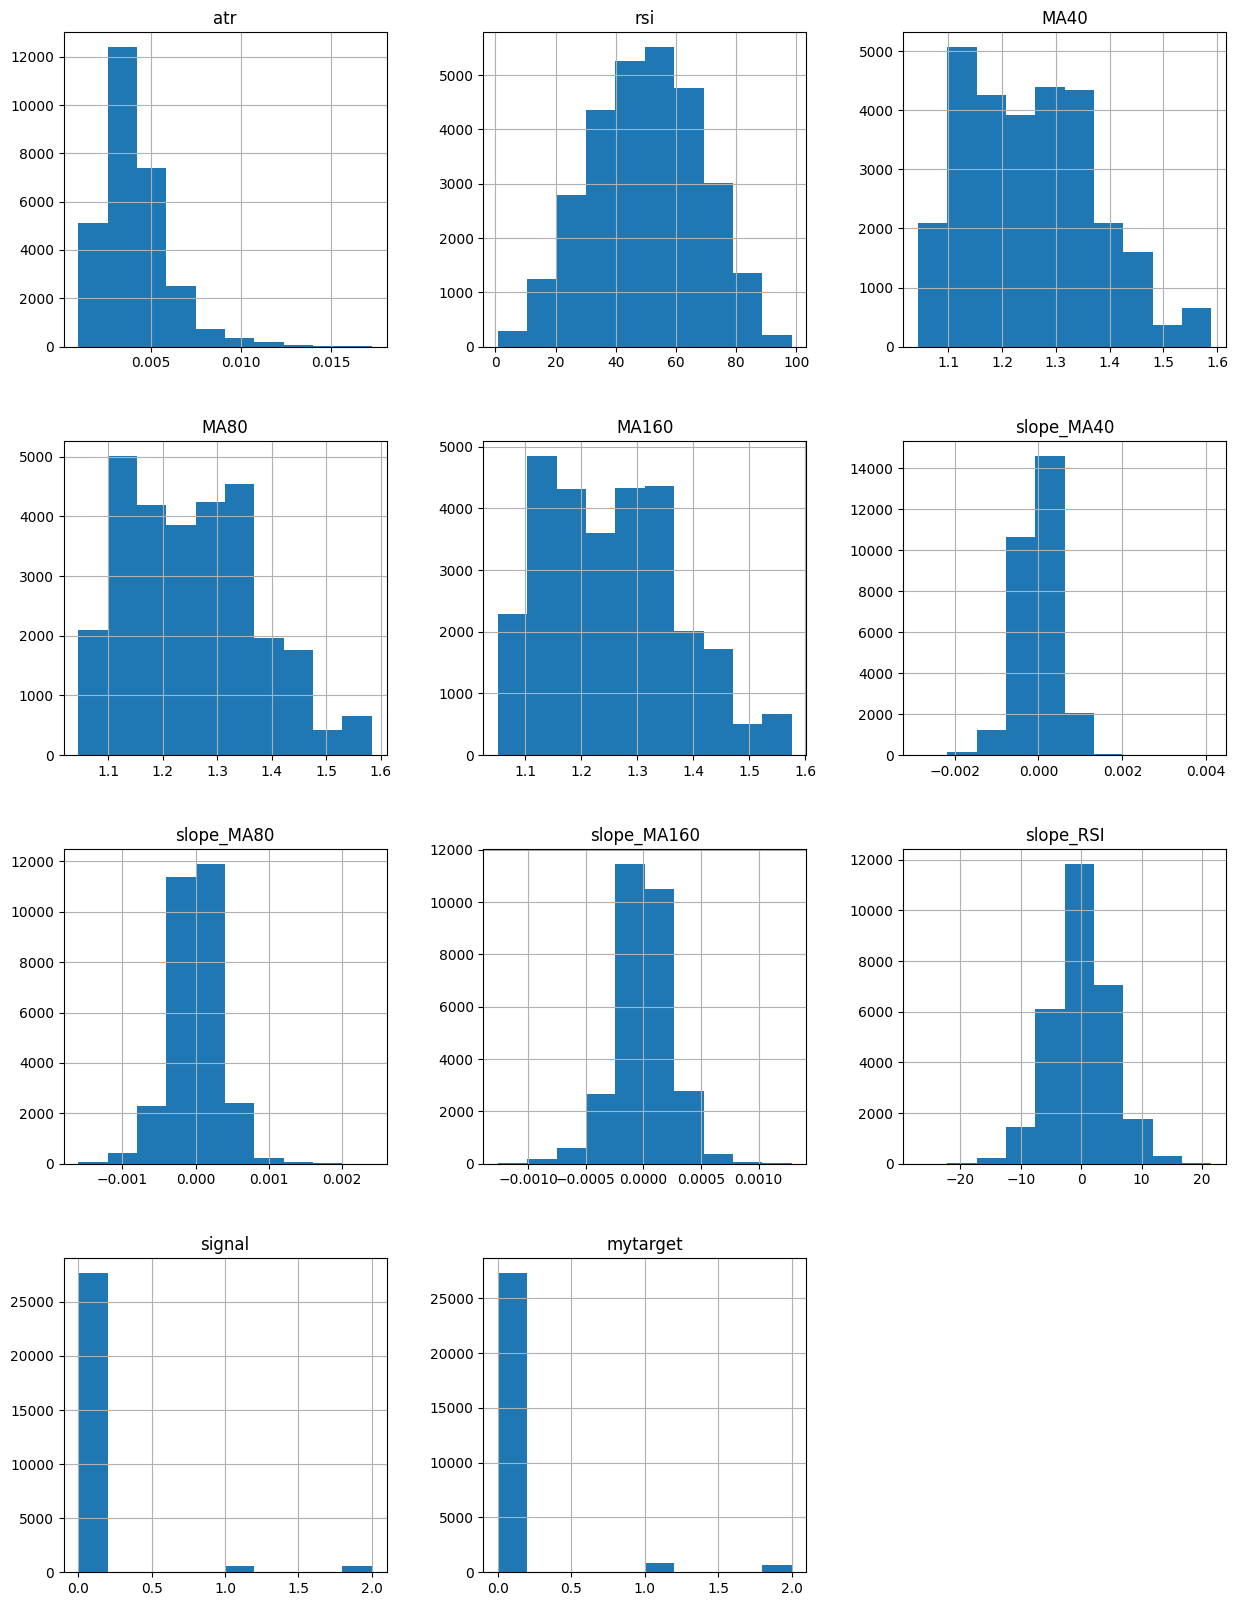

,Gmt time,open,high,low,close,volume,atr,rsi,MA40,MA80,MA160,slope_MA40,slope_MA80,slope_MA160,slope_RSI,signal,mytarget
28809,13.10.2021 01:00:00.000,1.15415,1.15559,1.15409,1.15527,4160.40,0.001775,38.146341,1.156751,1.161030,1.169864,-1.783750e-04,-0.000235,-0.000196,1.174136,0,0.0
28810,13.10.2021 05:00:00.000,1.15528,1.15604,1.15457,1.15565,11030.24,0.001811,41.210375,1.156594,1.160793,1.169667,-1.761250e-04,-0.000240,-0.000201,-0.485649,0,0.0
28811,13.10.2021 09:00:00.000,1.15564,1.15669,1.15363,1.15430,18650.34,0.001906,37.175043,1.156398,1.160550,1.169462,-1.397500e-04,-0.000220,-0.000197,5.747993,0,0.0
28812,13.10.2021 13:00:00.000,1.15430,1.15788,1.15405,1.15780,23598.19,0.002022,52.706360,1.156315,1.160352,1.169273,-4.125000e-05,-0.000168,-0.000182,11.826491,0,0.0
28813,13.10.2021 17:00:00.000,1.15781,1.15975,1.15780,1.15956,11188.68,0.001956,60.828025,1.156316,1.160213,1.169098,1.000000e-06,-0.000143,-0.000174,4.270639,0,0.0


In [17]:
import matplotlib.pyplot as plt

# Plot histograms
fig = plt.figure(figsize=(15, 20))
ax = fig.gca()
df_model = df[['atr',   'rsi',  'MA40', 'MA80', 'MA160',    'slope_MA40',   'slope_MA80',   'slope_MA160',  'slope_RSI',    'signal',   'mytarget']]
df_model.hist(ax=ax)
plt.show()
df.tail()

# سلول دهم : حذف مقادیر NA

In [ ]:
df_model=df_model.dropna()

# **سلول یازدهم: آموزش مدل**

In [18]:
# --- prepare attribute for the model
attributes = ['signal', 'atr', 'rsi', 'MA40', 'MA80', 'MA160', 'slope_MA40', 'slope_MA80', 'slope_MA160', 'slope_RSI']

# Ensure these attributes exist in the dataframe
X = df_model[attributes]
y = df_model['mytarget']

# Split data into (train) and (test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Hyperparameter tuning forxgbost model
param_grid = {
    'n_estimators': [50, 100, 200],   # Number of trees in the XGBoost model.
    'max_depth': [3, 6, 9],    # Maximum depth of each tree (how complex the trees can be).
    'learning_rate': [0.01, 0.1, 0.3]  # Controls how fast the model adjusts with each step during training.
}

# Cross-validation and GridSearch
xgb = XGBClassifier(random_state=42)
grid_search = GridSearchCV(xgb, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

# Best model from GridSearchCV
best_model = grid_search.best_estimator_

# Predictions and accuracy
y_pred_train = best_model.predict(X_train)
y_pred_test = best_model.predict(X_test)

acc_train = accuracy_score(y_train, y_pred_train)
acc_test = accuracy_score(y_test, y_pred_test)


print(f"Best Parameters: {grid_search.best_params_}")
print(f"Train Accuracy: {acc_train:.4%}")
print(f"Test Accuracy: {acc_test:.4%}")
print("\nClassification Report for Train:\n")
print(classification_report(y_train, y_pred_train))

print("\nClassification Report for Test:\n")
print(classification_report(y_test, y_pred_test))

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best Parameters: {'learning_rate': 0.3, 'max_depth': 6, 'n_estimators': 200}
Train Accuracy: 100.0000%
Test Accuracy: 96.6108%

Classification Report for Train:

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     19119
         1.0       1.00      1.00      1.00       552
         2.0       1.00      1.00      1.00       498

    accuracy                           1.00     20169
   macro avg       1.00      1.00      1.00     20169
weighted avg       1.00      1.00      1.00     20169


Classification Report for Test:

              precision    recall  f1-score   support

         0.0       0.97      0.99      0.98      8194
         1.0       0.82      0.44      0.57       255
         2.0       0.81      0.45      0.58       196

    accuracy                           0.97      8645
   macro avg       0.87      0.63      0.71      8645
weighted avg       0.96      0.97  

# سلول 10.5: ایجاد و آموزش مدل LSTM

In [ ]:
# %% [markdown]
# # 10.5 Build and Train LSTM Model
# %%
# Import necessary libraries
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
import tensorflow as tf

# Split data into training and validation sets
X_train_lstm, X_val_lstm, y_train_lstm, y_val_lstm = train_test_split(X_lstm, y_lstm, test_size=0.2, random_state=42, shuffle=False)

# Define the LSTM model
model_lstm = Sequential()

# First LSTM layer
model_lstm.add(LSTM(units=128, return_sequences=True, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])))
model_lstm.add(Dropout(0.2))

# Second LSTM layer
model_lstm.add(LSTM(units=64, return_sequences=False))
model_lstm.add(Dropout(0.2))

# Output layer
model_lstm.add(Dense(units=1))

# Compile the model
optimizer = Adam(learning_rate=0.001)
model_lstm.compile(optimizer=optimizer, loss='mean_squared_error')

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
model_lstm.fit(X_train_lstm, y_train_lstm, epochs=100, batch_size=32, validation_data=(X_val_lstm, y_val_lstm), callbacks=[early_stopping])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
720/720 ━━━━━━━━━━━━━━━━━━━━ 91s 120ms/step - loss: nan - val_loss: nan
Epoch 2/100
720/720 ━━━━━━━━━━━━━━━━━━━━ 147s 128ms/step - loss: nan - val_loss: nan
Epoch 3/100
251/720 ━━━━━━━━━━━━━━━━━━━━ 53s 114ms/step - loss: nan

In [ ]:
# %% [markdown]
# # 10.7 LSTM prediction and merge with XGBoost
# %%
# Predict with LSTM model
lstm_predictions_scaled = model_lstm.predict(X_lstm)
# Reshape predictions to original shape
lstm_predictions_scaled = lstm_predictions_scaled.reshape(-1, 1)
# Create a dummy array with the same shape as the lstm_predictions_scaled
dummy_array = np.zeros((lstm_predictions_scaled.shape[0], len(lstm_columns)))
# Replace the first column of the dummy array with the lstm_predictions_scaled
dummy_array[:, 0] = lstm_predictions_scaled[:, 0]
# Inverse transform the dummy array to get the original scale predictions
lstm_predictions = scaler.inverse_transform(dummy_array)[:, 0]

# Add LSTM predictions to the DataFrame
df_lstm = df[sequence_length:].copy() #lstm data from sequence length
df_lstm['lstm_prediction'] = lstm_predictions

# merge two data frame
df_model = pd.merge(df_lstm, df_model, how='inner')
# Drop NA values
df_model.dropna(inplace=True)

In [ ]:
# %% [markdown]
# # 66 Model Training
# %%
# --- prepare attribute for the model
# include lstm_prediction in features
attributes = ['signal', 'atr', 'rsi', 'MA40', 'MA80', 'MA160', 'slope_MA40', 'slope_MA80', 'slope_MA160', 'slope_RSI','lstm_prediction']

# Ensure these attributes exist in the dataframe
X = df_model[attributes]
y = df_model['mytarget']

# Split data into (train) and (test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=False)

# Hyperparameter tuning forxgbost model
param_grid = {
    'n_estimators': [50, 100, 200],   # Number of trees in the XGBoost model.
    'max_depth': [3, 6, 9],    # Maximum depth of each tree (how complex the trees can be).
    'learning_rate': [0.01, 0.1, 0.3]  # Controls how fast the model adjusts with each step during training.
}

# Cross-validation and GridSearch
xgb = XGBClassifier(random_state=42)
grid_search = GridSearchCV(xgb, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

# Best model from GridSearchCV
best_model = grid_search.best_estimator_

# Predictions and accuracy
y_pred_train = best_model.predict(X_train)
y_pred_test = best_model.predict(X_test)

acc_train = accuracy_score(y_train, y_pred_train)
acc_test = accuracy_score(y_test, y_pred_test)


print(f"Best Parameters: {grid_search.best_params_}")
print(f"Train Accuracy: {acc_train:.4%}")
print(f"Test Accuracy: {acc_test:.4%}")
print("\nClassification Report for Train:\n")
print(classification_report(y_train, y_pred_train))

print("\nClassification Report for Test:\n")
print(classification_report(y_test, y_pred_test))

In [ ]:
# %%
attributes = ['signal', 'atr', 'rsi', 'MA40', 'MA80', 'MA160', 'slope_MA40', 'slope_MA80', 'slope_MA160', 'slope_RSI','lstm_prediction']


# Ensure these attributes exist in the dataframe
X = df_model[attributes]
y = df_model['mytarget']

# Train/test split
train_pct_index = int(0.7 * len(X))
X_train, X_test = X[:train_pct_index], X[train_pct_index:]
y_train, y_test = y[:train_pct_index], y[train_pct_index:]

# XGBoost model training
model = XGBClassifier()
model.fit(X_train, y_train)
pred_train = model.predict(X_train)
pred_test = model.predict(X_test)

# Calculate accuracy
acc_train = accuracy_score(y_train, pred_train)
acc_test = accuracy_score(y_test, pred_test)

# Calculate total trades, total wins, and total losses
total_trades = len(pred_test)
total_wins = ((pred_test == 1) & (y_test == 1)).sum()  # Correctly predicted wins
total_losses = ((pred_test == 0) & (y_test == 0)).sum()  # Correctly predicted losses

print('Train Results')
print("Accuracy: {:.4%}".format(acc_train))
print('Test Results')
print("Accuracy: {:.4%}".format(acc_test))


print(classification_report(y_train, y_pred_train))
print(classification_report(y_test, y_pred_test))

# 77 Feature Importance Visualization

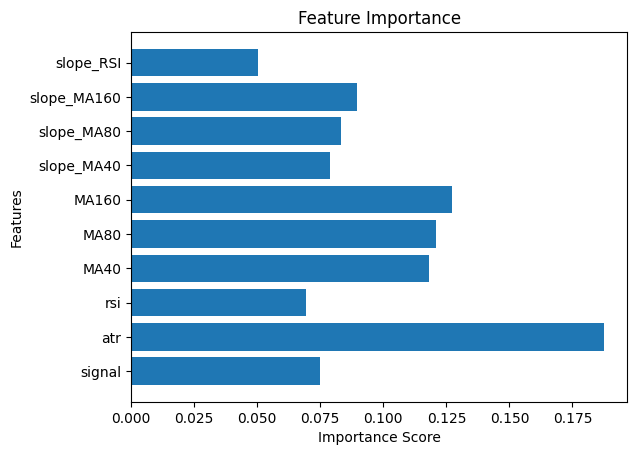

In [ ]:
# Feature ploting
importance = best_model.feature_importances_
plt.barh(attributes, importance)
plt.title('Feature Importance')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.show()

In [ ]:
# Calculate win/loss for the training set
train_wins = (y_train == y_pred_train).sum()
train_losses = len(y_train) - train_wins

# Calculate win/loss for the test set
test_wins = (y_test == y_pred_test).sum()
test_losses = len(y_test) - test_wins

# Total trades, wins, and losses
total_trades = len(y_train) + len(y_test)
total_wins = train_wins + test_wins
total_losses = total_trades - total_wins

# Output the results
print(f"Total Trades: {total_trades}")
print(f"Winning Trades: {total_wins}")
print(f"Losing Trades: {total_losses}")

Total Trades: 28636
Winning Trades: 28194
Losing Trades: 442


In [ ]:
# %%
import pandas as pd
import numpy as np
from backtesting import Backtest, Strategy

import pandas as pd
from backtesting import Strategy, Backtest

# rename columns
df_model.rename(columns={
    'open': 'Open',
    'high': 'High',
    'low': 'Low',
    'close': 'Close',
    'volume': 'Volume'
}, inplace=True)

# Define the signal function
def SIGNAL():
    return df_model['signal']

# Strategy class for backtesting
class MyCandlesStrat(Strategy):
    def init(self):
        super().init()
        # Load the buy/sell signal from the dataframe
        self.signal1 = self.I(SIGNAL)

    def next(self):
        super().next()
        # Check if there's already an open position
        if self.signal1 == 2:  # Buy signal
            # Close any posision open for short positions
            if self.position.is_short:
                self.position.close()
            # ---new long position open (buy)
            self.buy()

        elif self.signal1 == 1:  # Sell signal
            # Close any position open l for ong positions
            if self.position.is_long:
                self.position.close()
            # ---new short position open (sell)
            self.sell()

# Running the backtest on your dataframe
bt = Backtest(df_model[['Open', 'High', 'Low', 'Close']], MyCandlesStrat, cash=10_000, commission=.00)
stats = bt.run()

# Print backtest stats
print(stats)

# Plotting the strategy performance
bt.plot()

In [ ]:
model_lstm.save('model_lstm.h5')  # برای مدل lstm
import pickle
pickle.dump(best_model, open('model_xgboost.pkl', 'wb'))  # برای مدل xgboost

In [ ]:
from tensorflow.keras.models import load_model
model_lstm = load_model('model_lstm.h5')  # برای مدل lstm
import pickle
model_xgboost = pickle.load(open('model_xgboost.pkl', 'rb')) # برای مدل xgboost

# **ایجاد و ذخیره مدل:**

In [ ]:
# %%
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import load_model
import pickle

class LiveTradingModel:
    def __init__(self, lstm_model_path, xgboost_model_path, sequence_length=60):
        """
        Initializes the live trading model by loading the LSTM and XGBoost models.

        Args:
            lstm_model_path (str): Path to the saved LSTM model.
            xgboost_model_path (str): Path to the saved XGBoost model.
            sequence_length (int): The length of the sequence used for LSTM.
        """
        self.lstm_model = load_model(lstm_model_path)
        self.xgboost_model = pickle.load(open(xgboost_model_path, 'rb'))
        self.scaler = MinMaxScaler(feature_range=(0, 1))
        self.sequence_length = sequence_length
        self.lstm_columns = ['close', 'open', 'high', 'low', 'volume','atr', 'rsi', 'MA40', 'MA80', 'MA160', 'slope_MA40', 'slope_MA80', 'slope_MA160', 'slope_RSI', 'signal']

    def _calculate_features(self, df):
        """
        Calculates the necessary features (ATR, RSI, moving averages, slopes, signal) from the raw data.

        Args:
            df (pd.DataFrame): The raw DataFrame.

        Returns:
            pd.DataFrame: The DataFrame with the calculated features.
        """
        # Calculate ATR
        def calculate_atr(df, length=20):
            df['high_low'] = df['high'] - df['low']
            df['high_close'] = np.abs(df['high'] - df['close'].shift(1))
            df['low_close'] = np.abs(df['low'] - df['close'].shift(1))
            df['tr'] = df[['high_low', 'high_close', 'low_close']].max(axis=1)
            df['atr'] = df['tr'].rolling(window=length).mean()
            return df

        # Calculate RSI
        def calculate_rsi(df, length=14):
            delta = df['close'].diff(1)
            gain = (delta.where(delta > 0, 0)).rolling(window=length).mean()
            loss = (-delta.where(delta < 0, 0)).rolling(window=length).mean()
            rs = gain / loss
            df['rsi'] = 100 - (100 / (1 + rs))
            return df

        # Calculate moving averages
        def calculate_moving_averages(df, lengths=[40, 80, 160]):
            for length in lengths:
                df[f'MA{length}'] = df['close'].rolling(window=length).mean()
            return df

        # Calculate slope
        def calculate_slope(series):
            slope = np.gradient(series)
            return pd.Series(slope, name=f'{series.name}_slope')

        # Calculate signal
        def support(df, l, n1, n2):  #check if a given level 1 is a support level using n1 and n2 candles before and after the level.
            for i in range(l - n1 + 1, l + 1):
                if df['low'][i] > df['low'][i - 1]:   #iflow is higher than the previous one,
                    return 0
            for i in range(l + 1, l + n2 + 1):
                if df['low'][i] < df['low'][i - 1]:   #If a low is lower than the previous one
                    return 0
            return 1

        def resistance(df, l, n1, n2):
            for i in range(l - n1 + 1, l + 1):
                if df['high'][i] < df['high'][i - 1]:
                    return 0
            for i in range(l + 1, l + n2 + 1):
                if df['high'][i] > df['high'][i - 1]:
                    return 0
            return 1

        # Engulfing \ Star Pattern with Identification
        def isEngulfing(row, open_, close_):
            bodydiffmin = 0.002
            bodydiff = abs(open_[row] - close_[row])
            prev_bodydiff = abs(open_[row - 1] - close_[row - 1])

            if bodydiff < 0.000001:
                bodydiff = 0.000001

            if bodydiff > bodydiffmin and prev_bodydiff > bodydiffmin and open_[row - 1] < close_[row - 1] and open_[row] > close_[row]:
                return 1  # ---Bearish Engulfing
            elif bodydiff > bodydiffmin and prev_bodydiff > bodydiffmin and open_[row - 1] > close_[row - 1] and open_[row] < close_[row]:
                return 2  # ----Bullish Engulfing
            return 0

        def isStar(l, open_, close_, high, low):
            bodydiffmin = 0.0020
            bodydiff = abs(open_[l] - close_[l])
            highdiff = high[l] - max(open_[l], close_[l])
            lowdiff = min(open_[l], close_[l]) - low[l]

            if bodydiff < 0.000001:
                bodydiff = 0.000001

            ratio1 = highdiff / bodydiff
            ratio2 = lowdiff / bodydiff

            if ratio1 > 1 and lowdiff < 0.2 * highdiff and bodydiff > bodydiffmin:
                return 1  # ---Bearish Star
            elif ratio2 > 1 and highdiff < 0.2 * lowdiff and bodydiff > bodydiffmin:
                return 2  # ---Bullish Star
            return 0

        # Signal Generation Logic
        def generate_signals(df, n1=2, n2=2, backCandles=30, lim=150e-5):
            signal = [0] * len(df)
            open_ = df['open']
            close_ = df['close']
            high = df['high']
            low = df['low']

            for row in range(backCandles, len(df) - n2):
                ss = []   #support
                rr = []   #resistence
                for subrow in range(row - backCandles + n1, row + 1):
                    if support(df, subrow, n1, n2):
                        ss.append(low[subrow])
                    if resistance(df, subrow, n1, n2):
                        rr.append(high[subrow])

                # Signal Generation based on Engulfing and Star patterns
                engulfing_pattern = isEngulfing(row, open_, close_)
                star_pattern = isStar(row, open_, close_, high, low)

                if ((engulfing_pattern == 1 or star_pattern == 1) and closeResistance(row, rr, lim)):
                    signal[row] = 1  # --Sell Signal
                elif ((engulfing_pattern == 2 or star_pattern == 2) and closeSupport(row, ss, lim)):
                    signal[row] = 2  # --Buy Signal
                else:
                    signal[row] = 0  #-- No Signal

            df['signal'] = signal
            return df

        def closeResistance(l, levels, lim):
            if len(levels) == 0:
                return 0
            return (abs(df['high'][l] - min(levels, key=lambda x: abs(x - df['high'][l]))) <= lim)

        def closeSupport(l, levels, lim):
            if len(levels) == 0:
                return 0
            return (abs(df['low'][l] - min(levels, key=lambda x: abs(x - df['low'][l]))) <= lim)
        # Apply feature calculation functions
        df = calculate_atr(df)
        df = calculate_rsi(df)
        df = calculate_moving_averages(df, lengths=[40, 80, 160])

        # Add slopes
        df['slope_MA40'] = calculate_slope(df['MA40'])
        df['slope_MA80'] = calculate_slope(df['MA80'])
        df['slope_MA160'] = calculate_slope(df['MA160'])
        df['slope_RSI'] = calculate_slope(df['rsi'])

        # Clean up temporary columns
        df.drop(columns=['high_low', 'high_close', 'low_close', 'tr'], inplace=True)

        # Generate trading signals
        df = generate_signals(df)
        return df
    def _prepare_data_for_lstm(self, df):
        """
        Prepares the data for LSTM model, including scaling and sequence creation.

        Args:
            df (pd.DataFrame): The DataFrame to prepare.

        Returns:
            np.ndarray: The prepared data in the format expected by LSTM.
            MinMaxScaler: The scaler used to transform the data.
        """
        lstm_data = df[self.lstm_columns].copy()
        scaled_data = self.scaler.fit_transform(lstm_data)

        X_lstm = []
        for i in range(self.sequence_length, len(scaled_data)):
            X_lstm.append(scaled_data[i-self.sequence_length:i])
        X_lstm = np.array(X_lstm)
        return X_lstm

    def _prepare_data_for_xgboost(self, df):
        """
        Prepares the data for XGBoost model, including adding LSTM predictions.

        Args:
            df (pd.DataFrame): The DataFrame to prepare.

        Returns:
            pd.DataFrame: The prepared data with LSTM predictions.
        """
        X_lstm = self._prepare_data_for_lstm(df)
        lstm_predictions_scaled = self.lstm_model.predict(X_lstm)
        lstm_predictions_scaled = lstm_predictions_scaled.reshape(-1, 1)
        dummy_array = np.zeros((lstm_predictions_scaled.shape[0], len(self.lstm_columns)))
        dummy_array[:, 0] = lstm_predictions_scaled[:, 0]
        lstm_predictions = self.scaler.inverse_transform(dummy_array)[:, 0]

        df_lstm = df[self.sequence_length:].copy()
        df_lstm['lstm_prediction'] = lstm_predictions

        # merge two data frame
        df_model = df_lstm.copy()
        return df_model

    # Define Target Flexible Logic
    def mytarget(self, barsupfront, df, pipdiff=250e-4, SLTPRatio=1):
        length = len(df)
        high = list(df['high'])
        low = list(df['low'])
        close = list(df['close'])
        open = list(df['open'])

        trendcat = [None] * length  #  store all the trend classification

        for line in range(length - barsupfront - 2):
            valueOpenLow = 0
            valueOpenHigh = 0

            for i in range(1, barsupfront + 2):
                value1 = open[line + 1] - low[line + i]   # potential in down trend
                value2 = open[line + 1] - high[line + i]   # potential up tren

                valueOpenLow = max(value1, valueOpenLow)
                valueOpenHigh = min(value2, valueOpenHigh)

                if (valueOpenLow >= pipdiff and -valueOpenHigh <= (pipdiff / SLTPRatio)):
                    trendcat[line] = 1  # --Downtrend
                    break
                elif (valueOpenLow <= (pipdiff / SLTPRatio) and -valueOpenHigh >= pipdiff):
                    trendcat[line] = 2  # --Uptrend
                    break
                else:
                    trendcat[line] = 0  # --No trend

        return trendcat

    def predict(self, df_raw):
        """
        Makes predictions and generate signals on new raw data using the combined model.

        Args:
            df_raw (pd.DataFrame): The raw DataFrame to predict on.

        Returns:
            pd.DataFrame: The final predictions and signals DataFrame.
        """
        df = df_raw.copy()

        # Calculate features
        df = self._calculate_features(df)
        # prepare data for xgboost
        prepared_df = self._prepare_data_for_xgboost(df)
        #create attribute for model
        attributes = ['signal', 'atr', 'rsi', 'MA40', 'MA80', 'MA160', 'slope_MA40', 'slope_MA80', 'slope_MA160', 'slope_RSI','lstm_prediction']
        # Get final prepared_df for model
        X_new = prepared_df[attributes]
        # predict and return prediced result
        predictions = self.xgboost_model.predict(X_new)
        #create target
        prepared_df['mytarget'] = self.mytarget(16, prepared_df)
        prepared_df.dropna(subset=['mytarget'], inplace=True)
        prepared_df['predictions'] = predictions
        return prepared_df

    def save(self, filename):
        """
        Saves the live trading model to a file.

        Args:
            filename (str): The name of the file to save the model to.
        """
        with open(filename, 'wb') as f:
            pickle.dump(self, f)

    @staticmethod
    def load(filename):
        """
        Loads a live trading model from a file.

        Args:
            filename (str): The name of the file to load the model from.

        Returns:
            LiveTradingModel: The loaded live trading model.
        """
        with open(filename, 'rb') as f:
            return pickle.load(f)

# Create and save the live trading model
live_model = LiveTradingModel('model_lstm.h5', 'model_xgboost.pkl')
live_model.save('live_model.pkl')

# **نحوه بارگذاری و استفاده از مدل ذخیره شده:**

In [ ]:
# %%
# Load the live trading model
loaded_live_model = LiveTradingModel.load('live_model.pkl')

# Example usage with new raw data (df_new_raw)
# Assuming df_new_raw is your new raw DataFrame with columns ['open', 'high', 'low', 'close', 'volume']
df_new_raw = df[['open','high','low','close','volume']].copy()
final_result = loaded_live_model.predict(df_new_raw)
print(final_result)